In [3]:
# import mnist dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
# examine arrays
X,y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

# transfer y to integer
import numpy as np
y = y.astype(np.uint8)

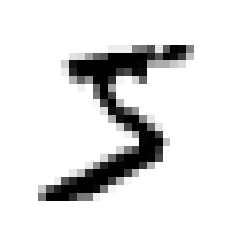

5

In [14]:
# visualize
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()
y[0]

In [6]:
# split into train and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
### Stochastic Gradient Descent (SGD) classifier

In [7]:
# create target vectors for the classification task
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [8]:
# Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [35]:
# cross validation with evaluation scores from each iteration
from sklearn.model_selection import cross_val_score

print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')) 
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='precision')) 
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='recall'))
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='f1')) 

[0.95035 0.96035 0.9604 ]
[0.95936795 0.89060092 0.74963109]
[0.47039292 0.63973437 0.84338683]
[0.63126625 0.74460548 0.79375   ]


In [13]:
# cross validation with evaluation scores averaged from all iterations
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

print(confusion_matrix(y_train_5, y_train_pred))
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))

[[53892   687]
 [ 1891  3530]]
0.8370879772350012
0.6511713705958311
0.7325171197343846


Interpretation on precision and recall:

When the classifer claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

In [18]:
# get decision score
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

# change decision threshold
threshold2 = 8000
y_some_digit_pred2 = (y_scores > threshold2)
print(y_some_digit_pred2)

[2164.22030239]
[ True]
[False]


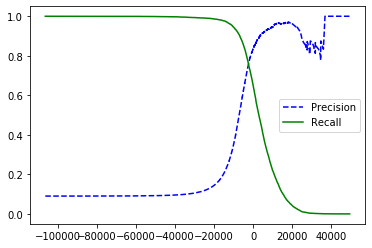

In [44]:
# create precision-recall (PR) curve
# get decision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.show()

In [29]:
# get the lowest threshold that gives at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

3370.0194991439557
0.9000345901072293
0.4799852425751706


0.9604938554008616


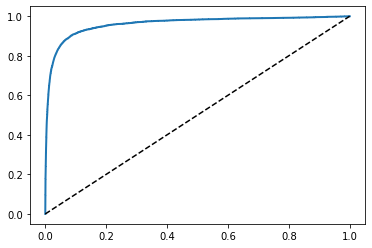

In [32]:
# create receiver operating characteristic (ROC) curve 
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    
plot_roc_curve(fpr, tpr)
plt.show()

# calculate area under the curve (AUC) score
print(roc_auc_score(y_train_5, y_scores))

### Random Forest classifier

In [42]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

# get decision scores
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


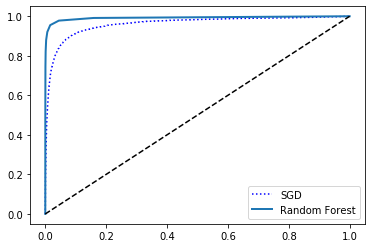

0.9920527492698306

In [45]:
y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

roc_auc_score(y_train_5, y_scores_forest)

## Multiclass Classification

In [47]:
# SGD classifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

np.argmax(some_digit_scores)
sgd_clf.classes_
sgd_clf.classes_[5]

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


5

In [50]:
# evaluation
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87082583, 0.87089354, 0.88628294])

In [51]:
# improve accuracy with scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87082583, 0.87089354, 0.88628294])

In [48]:
# OneVsOneClassifier and OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

In [49]:
# random forest classifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

# get the list of probabilities that the classifier assigned to each instance for each class
forest_clf.predict_proba([some_digit])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

## Error Analysis

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[[5576    0   21    6    9   43   37    6  224    1]
 [   0 6398   38   23    4   44    4    8  213   10]
 [  26   27 5242   90   71   26   62   36  371    7]
 [  24   17  117 5220    2  208   28   40  405   70]
 [  12   14   48   10 5192   10   36   26  330  164]
 [  28   15   33  166   55 4437   76   14  538   59]
 [  30   14   41    2   43   95 5560    4  128    1]
 [  21    9   52   27   51   12    3 5693  188  209]
 [  17   63   46   90    3  125   25   10 5429   43]
 [  23   18   31   66  116   32    1  179  377 5106]]


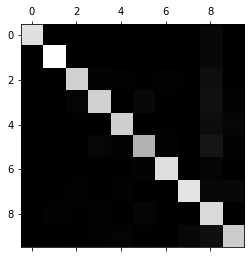

In [55]:
# confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

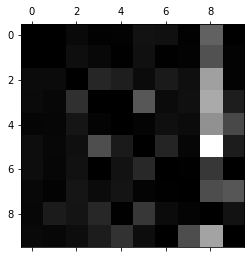

In [54]:
# calculate error rates
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill the diagonal with zeros
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multilabel Classification

In [56]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # whether the digit is large (7,8,9)
y_train_odd = (y_train % 2 == 1) # whether the digit is odd
y_multilabel = np.c_[y_train_large, y_train_odd] # y_multilabel array containing two target labels for each digit

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit]) # digit 5 is not large (False) and odd (True)

# evaluate the classifier 
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

## Multioutput Classification

In [57]:
# add noise 
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train

y_test_mod = X_test

In [59]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_digit]])
plot_digit(clean_digit)

IndexError: arrays used as indices must be of integer (or boolean) type